In [143]:
'''
    Downloading Data
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("regulations.csv")
df['publication_date'] = pd.to_datetime(df['publication_date'])
answers = pd.read_csv("train_answer.csv")
df.head()
# len(df)
# df.isnull().sum()

,id,act_title,publication_date,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution,problem_addressed,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance
0,5038,Об утверждении тарифов на услуги по транспорти...,2013-09-11,ФСТ России,NaN,376.0,0.0,0.0,0.0,Низкая,Митина Ольга Викторовна,Митина Ольга Викторовна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
1,5039,О внесении изменений в отдельные законодательн...,2013-06-11,Минтруд России,Здравоохранение; Предоставление социальных услуг,504.0,0.0,0.0,0.0,Низкая,Рахов Виталий Сергеевич,Павлова Зоя Ивановна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
2,5040,Об утверждении Положения об уведомлении лиц об...,2013-04-29,Росфинмониторинг,Финансовая деятельность,428.0,0.0,0.0,0.0,Низкая,Тимофеева Алёна Игоревна,Лях Валерий Владимирович,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
3,5041,О внесении изменений в Положение о Министерств...,2013-10-21,Минобрнауки России,Образование,376.0,0.0,0.0,0.0,Низкая,Вотоновская Ирина Вячеславовна,Михайлова Ирина Вячеславовна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
4,5042,О внесении изменений в Правила подготовки и пр...,2014-02-24,Минприроды России,NaN,499.0,0.0,0.0,0.0,Низкая,Соболева Светлана Юрьевна,Соболева Светлана Юрьевна,False,False,Не определено,предоставление водного объекта в пользование п...,Пунктом 12 части 2 статьи 11 Водного кодекса Р...,неопределенный круг лиц,необходимость корреляции Правил подготовки и п...,Проект постановления Правительства Российской ...


In [154]:
'''
    Preparing Data
'''
#Get rid of nans
for col in df:
    #get dtype for column
    dt = df[col].dtype 
    #check if it is a number
    if dt == int or dt == float or dt == 'float64':
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna("nothing")
        
df1 = df.loc[:,['id', 'act_title', 'developer', 'okved_list', 'views_num', 'dislikes_num', 'regulatory_impact', 
                'is_regionally_signigicant', 'act_changes_controlling_activities', 'mineco_solution',
                'problem_addressed', 'act_objectives', 'persons_affected_by_act',
                'relations_regulated_by_act','act_significance']]
df1.loc[:,'regulatory_impact'] = [2 if i=="Высокая" else 1 if i=="Средняя" else 0 for i in df1['regulatory_impact']]
df1.loc[:,'mineco_solution'] = [1 if i=="Положительное" else -1 if i=="Отрицательное"
                                else 0 for i in df1['mineco_solution']]
df1.loc[:,['is_regionally_signigicant']] = [1 if i == True else 0 for i in df1['is_regionally_signigicant']]
df1.loc[:,['act_changes_controlling_activities']] = [1 if i == True else 0 
                                                     for i in df1['act_changes_controlling_activities']]
df1.loc[:,['problem_addressed', 'act_objectives', 'persons_affected_by_act', 'relations_regulated_by_act',
           'act_significance']] = df1.loc[:,['problem_addressed', 'act_objectives', 'persons_affected_by_act',
                'relations_regulated_by_act','act_significance']].applymap(lambda x: 0 if x=='nothing' else 1)
df1['okved_list'] = [0 if x=='nothing' else 1 for x in df1['okved_list']]


#Dealing with persons (added_by and responsible)
df1['same_person'] = (df['added_by'] == df['responsible'])
responsible = pd.DataFrame(np.unique(df['responsible'], return_counts=True)).transpose()
responsible = dict(zip(responsible[0], responsible[1]))
responsible['nothing'] = 0
added_by = pd.DataFrame(np.unique(df['added_by'], return_counts=True)).transpose()
added_by = dict(zip(added_by[0], added_by[1]))
added_by['nothing'] = 0
#added_by
df1['responsible_count'] = [responsible[x] for x in df['responsible']]
df1['added_by_count'] = [added_by[x] for x in df['added_by']]


def first_word(table, word):
    '''
        adding feature that the 1st word in act_title is equal to word
    '''
    table[word] = [1 if x.split()[0].strip(string.punctuation).strip('«').lower() == word else 0 
                   for x in table['act_title']]

#first_word(df1, 'федеральный')   
    
A = pd.DataFrame(df['act_title'])
A[0] = [x.split()[0].strip(string.punctuation).strip('«').lower() for x in A['act_title']]
for word in pd.DataFrame(np.unique(A[0], return_counts=True)
                         ).transpose().sort_values(1, ascending=False)[0][:10].values:
    first_word(df1, word)
del df1['act_title']



#dealing with developers
df1 = pd.get_dummies(df1,columns=["developer"], drop_first=True)

# df2 = pd.get_dummies(df,columns=["developer"], drop_first=True)
# df['developer'] = df['developer'].fillna('nothing')
# plt.figure(figsize=(20, 12))
# plt.bar(*np.unique(df['developer'], return_counts=True))
# plt.show()
df1['problem_addressed'].sum()


18501

In [155]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import sklearn

X = df1[df1['id'].isin(answers['id'])]
# X_res = df1[~df1['id'].isin(answers['id'])]

id_dict = dict(zip(answers['id'],answers['passed']))
y =np.array([id_dict[i] for i in X['id']])

# Result = pd.DataFrame(X_res['id'].copy()).reset_index(drop=True)
#display(Result)

del X['id']
# del X_res['id']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

eval_set = [(X_test, y_test)]
xg_cl = xgb.XGBClassifier(objective="binary:logistic", n_estimators=1000, seed=111)

xg_cl.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set, verbose=True)




predict = xg_cl.predict(X_train)
predict_proba = xg_cl.predict_proba(X_train)

print(f'Train F1: {sklearn.metrics.f1_score(y_train, predict)}')
print(f'Train roc_auc_score: {sklearn.metrics.roc_auc_score(y_train, pd.DataFrame(predict_proba)[1])}')





predict = xg_cl.predict(X_test)
predict_proba = xg_cl.predict_proba(X_test)

print(f'Test F1: {sklearn.metrics.f1_score(y_test, predict)}')
print(f'Test roc_auc_score: {sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1])}')





X_res = df1[~df1['id'].isin(answers['id'])]
Result = pd.DataFrame(X_res['id'].copy()).reset_index(drop=True)
del X_res['id']
predict_proba = xg_cl.predict_proba(X_res)
Result['passed'] = pd.DataFrame(predict_proba)[1]
Result.to_csv("result.csv", index=False)

Result

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.61346
[1]	validation_0-auc:0.64471
[2]	validation_0-auc:0.68975
[3]	validation_0-auc:0.70773
[4]	validation_0-auc:0.73843
[5]	validation_0-auc:0.74750
[6]	validation_0-auc:0.75900
[7]	validation_0-auc:0.77524
[8]	validation_0-auc:0.77677
[9]	validation_0-auc:0.78128
[10]	validation_0-auc:0.78601
[11]	validation_0-auc:0.78981
[12]	validation_0-auc:0.80495
[13]	validation_0-auc:0.81138
[14]	validation_0-auc:0.81444
[15]	validation_0-auc:0.81677
[16]	validation_0-auc:0.82089
[17]	validation_0-auc:0.82223
[18]	validation_0-auc:0.82296
[19]	validation_0-auc:0.82410
[20]	validation_0-auc:0.82979
[21]	validation_0-auc:0.83103
[22]	validation_0-auc:0.83232
[23]	validation_0-auc:0.83390
[24]	validation_0-auc:0.83740
[25]	validation_0-auc:0.83850
[26]	validation_0-auc:0.83982
[27]	validation_0-auc:0.84146
[28]	validation_0-auc:0.84226
[29]	validation_0-auc:0.84314
[30]	validation_0-auc:0.84405
[31]	validation_0-auc:0.84756
[32]	validation_0-auc:0.84761
[33]	validation_0-au

[268]	validation_0-auc:0.89888
[269]	validation_0-auc:0.89882
[270]	validation_0-auc:0.89867
[271]	validation_0-auc:0.89865
[272]	validation_0-auc:0.89862
[273]	validation_0-auc:0.89868
[274]	validation_0-auc:0.89869
[275]	validation_0-auc:0.89872
[276]	validation_0-auc:0.89876
[277]	validation_0-auc:0.89870
[278]	validation_0-auc:0.89862
[279]	validation_0-auc:0.89865
[280]	validation_0-auc:0.89863
[281]	validation_0-auc:0.89867
[282]	validation_0-auc:0.89860
[283]	validation_0-auc:0.89868
[284]	validation_0-auc:0.89863
[285]	validation_0-auc:0.89864
[286]	validation_0-auc:0.89861
[287]	validation_0-auc:0.89865
[288]	validation_0-auc:0.89875
[289]	validation_0-auc:0.89883
[290]	validation_0-auc:0.89898
[291]	validation_0-auc:0.89898
[292]	validation_0-auc:0.89920
[293]	validation_0-auc:0.89911
[294]	validation_0-auc:0.89906
[295]	validation_0-auc:0.89920
[296]	validation_0-auc:0.89919
[297]	validation_0-auc:0.89919
[298]	validation_0-auc:0.89920
[299]	validation_0-auc:0.89933
[300]	va

,id,passed
0,5042,0.007731
1,5076,0.125333
2,5091,0.005833
3,5097,0.004478
4,5101,0.106424
...,...,...
3995,119796,0.000881
3996,119823,0.000192
3997,119839,0.002612
3998,119858,0.000046


In [72]:
D = dict(zip(xg_cl.feature_importances_, X.columns))
A = pd.DataFrame(zip(xg_cl.feature_importances_, X.columns))
A = A.sort_values(0, ascending=False)
A.to_csv('importance.csv')

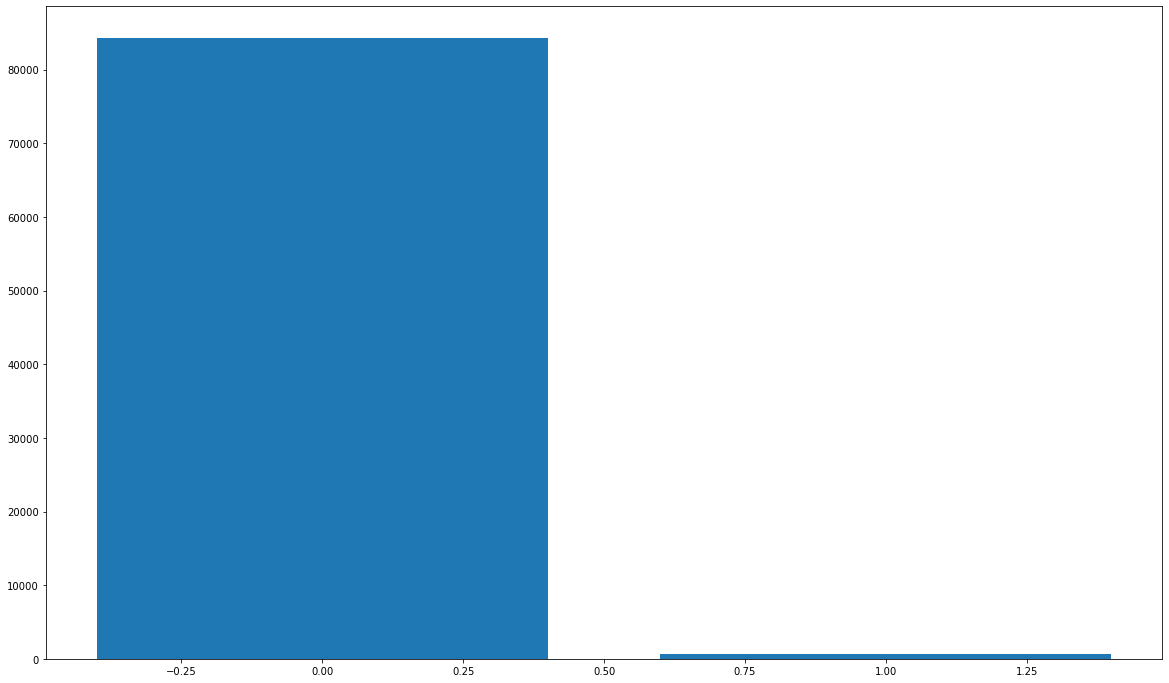

,publication_date,developer,views_num,dislikes_num,regulatory_impact,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution
0,2013-09-11 00:00:00,ФСТ России,376.0,0.0,0,0,0,0
1,2013-06-11 00:00:00,Минтруд России,504.0,0.0,0,0,0,0
2,2013-04-29 00:00:00,Росфинмониторинг,428.0,0.0,0,0,0,0
3,2013-10-21 00:00:00,Минобрнауки России,376.0,0.0,0,0,0,0
4,2014-02-24 00:00:00,Минприроды России,499.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...
85001,2021-09-10 00:00:00,Минфин России,24.0,0.0,0,0,0,0
85002,2021-09-10 00:00:00,Роспотребнадзор,40.0,0.0,0,0,0,0
85003,2021-09-10 00:00:00,Единый государственный заказчик в сфере строит...,11.0,0.0,0,0,0,0
85004,2021-09-10 00:00:00,Минэнерго России,13.0,0.0,0,0,0,0


In [181]:
plt.figure(figsize=(20, 12))
plt.bar(*np.unique(df1['is_regionally_signigicant'], return_counts=True))
plt.show()
# df1.loc[:,['is_regionally_signigicant']] = [1 if i == True else 0 for i in df1['is_regionally_signigicant']]
# np.unique(df1['is_regionally_signigicant'], return_counts=True)
# df1['is_regionally_signigicant'].sum()
# df1['publication_date'].str.replace("nothing","").dt.strftime("%Y%m%d").astype(int)#.str.replace("nothing","").astype(int)#.str.replace("-","")#.astype(int)

df1

In [137]:
import re
import string
A = pd.DataFrame(df['act_title'])
A[0] = [x.split()[0].strip(string.punctuation).strip('«').lower() for x in A['act_title']]
display(pd.DataFrame(np.unique(A[0], return_counts=True)).transpose().sort_values(1, ascending=False).head(20))

def first_word(table, word):
    '''
        adding feature that the 1st word in act_title is equal to word
    '''
    table[word] = [1 if x.split()[0].strip(string.punctuation).strip('«').lower() == word else 0 
                   for x in table['act_title']]


A = pd.DataFrame(df['act_title'])
A[0] = [x.split()[0].strip(string.punctuation).strip('«').lower() for x in A['act_title']]
for word in pd.DataFrame(np.unique(A[0], return_counts=True)
                         ).transpose().sort_values(1, ascending=False)[0][:10].values:
    first_word(df, word)
first_word(df, 'о')
df['о'].sum()
sum(df['проект'])

,0,1
82,о,40816
83,об,31983
136,проект,6829
126,приказ,2017
203,федеральный,1190
16,административный,470
110,постановление,444
108,порядок,130
116,правила,87
188,указ,56


6829

In [135]:
pd.DataFrame(np.unique(A[0], return_counts=True)
                         ).transpose().sort_values(1, ascending=False)[0][:10].values

array(['о', 'об', 'проект', 'приказ', 'федеральный', 'административный',
       'постановление', 'порядок', 'правила', 'указ'], dtype=object)

In [142]:
df1.columns[:20]

Index(['id', 'views_num', 'dislikes_num', 'regulatory_impact',
       'is_regionally_signigicant', 'act_changes_controlling_activities',
       'mineco_solution', 'problem_addressed', 'act_objectives',
       'persons_affected_by_act', 'relations_regulated_by_act',
       'act_significance', 'same_person', 'responsible_count',
       'added_by_count', 'о', 'об', 'проект', 'приказ', 'федеральный'],
      dtype='object')